In [2]:
#!nvidia-smi
#using a GeForce GTX1080 Ti for reproducibility for all timing experiments

In [3]:
import torch
import torchvision
from torch import nn, optim, autograd
from torch.nn import functional as F
import numpy as np
from sklearn.metrics import roc_auc_score
import scipy
from utils.LB_utils import * 
from utils.load_not_MNIST import notMNIST
import os
import time
import matplotlib.pyplot as plt

s = 1
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pytorch version:  1.5.0
cuda available:  True


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda_status = torch.cuda.is_available()
print("device: ", device)
print("cuda status: ", cuda_status)

# Load data

In [4]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

Files already downloaded and verified
Files already downloaded and verified


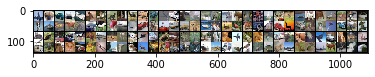

In [5]:
transform_base = [transforms.ToTensor()]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    ] + transform_base)

transform_test = transforms.Compose(transform_base)
transform_train = transforms.RandomChoice([transform_train, transform_test])

#~/data/cifar10
CIFAR10_trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_trainset, batch_size=BATCH_SIZE_TRAIN_CIFAR10, shuffle=True, num_workers=2)

#~/data/cifar10
CIFAR10_testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_testset, batch_size=BATCH_SIZE_TEST_CIFAR10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Files already downloaded and verified
Files already downloaded and verified


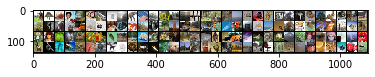

In [6]:
#load in CIFAR100
BATCH_SIZE_TRAIN_CIFAR100 = 128
BATCH_SIZE_TEST_CIFAR100 = 128

#'~/data/cifar100'
CIFAR100_train = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=True,
                                       download=True, transform=transform_train)
CIFAR100_train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=BATCH_SIZE_TRAIN_CIFAR100,
                                         shuffle=False)
#'~/data/cifar100'
CIFAR100_test = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_CIFAR100,
                                         shuffle=False)

CIFAR100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

dataiter = iter(CIFAR100_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR100/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

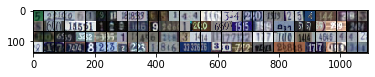

In [7]:
# load SVHN
BATCH_SIZE_TRAIN_SVHN = 128
BATCH_SIZE_TEST_SVHN = 128

#'~/data/SVHN'
train_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='train',
                             download=False, transform=transform_train)

#'~/data/SVHN'
test_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='test',
                             download=False, transform=transform_test)

SVHN_train_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TRAIN_SVHN)
SVHN_test_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)

dataiter = iter(SVHN_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_SVHN/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

# Train CIFAR10 on ResNet18 (or load weights)

In [ ]:
import torchvision.models as models
CIFAR10_model = models.resnet18(pretrained=True).to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CIFAR10_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [11]:
# Training
def train(net, epoch, optimizer, trainloader, filename):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    print("train loss: ", train_loss)
    print("train accuracy: ", correct/total)
    print("saving model at: {}".format(filename))
    torch.save(net.state_dict(), filename)

In [12]:
def test(net, epoch, testloader, path, save=False):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        acc = correct/total
        if acc > best_acc and save: 
            best_acc = acc
            print("saving model at: {}".format(path))
            torch.save(net.state_dict(), path)


        print("test loss: ", test_loss)
        print("current acc: {}; best acc: {}".format(acc, best_acc) )

In [13]:
# We know that you should not validate on your test data but our paper is not about the training process
# but rather about what you can do once you have a well-trained model. 

def train_all():
    CIFAR10_PATH = 'pretrained_weights/CIFAR10_resnet18_s{}.pth'.format(s)
    CIFAR10_PATH_BEST = 'pretrained_weights/CIFAR10_resnet18_best_s{}.pth'.format(s)
    lr = 0.1
    epoch = 0
    for e in [30, 50, 50]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(CIFAR10_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(CIFAR10_model, epoch, optimizer, CIFAR10_train_loader, CIFAR10_PATH)
            test(CIFAR10_model, epoch, CIFAR10_test_loader, save=True, path=CIFAR10_PATH_BEST)
            epoch += 1
        lr /= 10

In [14]:
##### uncomment this if you want to train a network ######

#t0 = time.time()
#train_all()
#t1 = time.time()
#print("training took: {} seconds".format(t1-t0))

In [15]:
#training took: 4288.249864578247 seconds which is 71.47 minutes

In [16]:
##### if you already have a trained model ##############
CIFAR10_PATH = 'pretrained_weights/CIFAR10_resnet18_pretrained.pth'
#CIFAR10_PATH = 'pretrained_weights/CIFAR10_resnet18_best_s{}.pth'.format(s)
CIFAR10_model = ResNet18().to(device)
print("loading model from: {}".format(CIFAR10_PATH))
CIFAR10_model.load_state_dict(torch.load(CIFAR10_PATH))#, map_location=torch.device('cpu')))
#test the model
test(CIFAR10_model, 0, CIFAR10_test_loader, save=False, path=CIFAR10_PATH)

loading model from: pretrained_weights/CIFAR10_resnet18_pretrained.pth
test loss:  14.309499010443687
current acc: 0.9542; best acc: 0


# MAP estimate

In [22]:
CIFAR10_test_in_MAP = predict_MAP(CIFAR10_model, CIFAR10_test_loader, cuda=cuda_status).cpu().numpy()
CIFAR10_test_out_CIFAR100_MAP = predict_MAP(CIFAR10_model, CIFAR100_test_loader, cuda=cuda_status).cpu().numpy()
CIFAR10_test_out_SVHN_MAP = predict_MAP(CIFAR10_model, SVHN_test_loader, cuda=cuda_status).cpu().numpy()

In [23]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(CIFAR10_test_in_MAP, targets_CIFAR10)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_CIFAR100_MAP, targets_CIFAR100)
acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_SVHN_MAP, targets_SVHN)

In [24]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR10', 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP, 'CIFAR10', 'SVHN', 'MAP')

[In, MAP, CIFAR10] Accuracy: 0.954; average entropy: 0.072;     MMC: 0.977; Prob @ correct: 0.100
[Out-CIFAR100, MAP, CIFAR10] Accuracy: 0.009; Average entropy: 0.547;    MMC: 0.811; AUROC: 0.879; Prob @ correct: 0.100
[Out-SVHN, MAP, CIFAR10] Accuracy: 0.092; Average entropy: 0.733;    MMC: 0.755; AUROC: 0.928; Prob @ correct: 0.100


# Diagonal estimate

In [ ]:
la_diag = Laplace(CIFAR10_model, 'classification', 
                     subset_of_weights='last_layer', 
                     hessian_structure='diag',
                     prior_precision=5e-4) # 5e-4 # Choose prior precision according to weight decay
la_diag.fit(CIFAR10_train_loader)

In [ ]:
CIFAR10_test_in_D = predict_samples(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_CIFAR100_D = predict_samples(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_SVHN_D = predict_samples(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()

In [27]:
CIFAR10_test_in_D = predict_diagonal_sampling(CIFAR10_model, CIFAR10_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_D = predict_diagonal_sampling(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_D = predict_diagonal_sampling(CIFAR10_model, SVHN_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()

time used for forward pass: 0.6632184982299805
time used for sampling with 1000 samples: 13.039254903793335
time used for forward pass: 0.6622967720031738
time used for sampling with 1000 samples: 13.119536876678467
time used for forward pass: 1.54921555519104
time used for sampling with 1000 samples: 30.521629333496094


In [29]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(CIFAR10_test_in_D, targets_CIFAR10)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_CIFAR100_D, targets_CIFAR100)
acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_SVHN_D, targets_SVHN)

In [30]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'CIFAR10', 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D, 'CIFAR10', 'SVHN', 'Diag')

[In, Diag, CIFAR10] Accuracy: 0.954; average entropy: 0.080;     MMC: 0.975; Prob @ correct: 0.100
[Out-CIFAR100, Diag, CIFAR10] Accuracy: 0.009; Average entropy: 0.581;    MMC: 0.798; AUROC: 0.880; Prob @ correct: 0.100
[Out-SVHN, Diag, CIFAR10] Accuracy: 0.092; Average entropy: 0.771;    MMC: 0.741; AUROC: 0.928; Prob @ correct: 0.100


# KFAC estimate

In [ ]:
la_kfac = Laplace(CIFAR10_model, 'classification', 
                     subset_of_weights='last_layer', 
                     hessian_structure='kron',
                     prior_precision=5e-4) # 5e-4 # Choose prior precision according to weight decay
la_kfac.fit(CIFAR10_train_loader)

In [ ]:
CIFAR10_test_in_KFAC = predict_samples(la_kfac, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_CIFAR100_KFAC = predict_samples(la_kfac, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_SVHN_KFAC = predict_samples(la_kfac, SVHN_test_loader, timing=True, device=device).cpu().numpy()

In [33]:
CIFAR10_test_in_K = predict_KFAC_sampling(CIFAR10_model, CIFAR10_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_K = predict_KFAC_sampling(CIFAR10_model, CIFAR100_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_K = predict_KFAC_sampling(CIFAR10_model, SVHN_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()

time used for sampling with 1000 samples: 11.090741634368896
time used for sampling with 1000 samples: 11.142581939697266
time used for sampling with 1000 samples: 31.652571201324463


In [34]:
acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K = get_in_dist_values(CIFAR10_test_in_K, targets_CIFAR10)
acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100_K, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K = get_out_dist_values(CIFAR10_test_in_K, CIFAR10_test_out_CIFAR100_K, targets_CIFAR100)
acc_out_SVHN_K, prob_correct_out_SVHN_K, ent_out_SVHN_K, MMC_out_SVHN_K, auroc_out_SVHN_K = get_out_dist_values(CIFAR10_test_in_K, CIFAR10_test_out_SVHN_K, targets_SVHN)

In [35]:
print_in_dist_values(acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K, 'CIFAR10', 'KFAC')
print_out_dist_values(acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100_K, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K, 'CIFAR10', 'CIFAR100', 'KFAC')
print_out_dist_values(acc_out_SVHN_K, prob_correct_out_SVHN_K, ent_out_SVHN_K, MMC_out_SVHN_K, auroc_out_SVHN_K, 'CIFAR10', 'SVHN', 'KFAC')

[In, KFAC, CIFAR10] Accuracy: 0.954; average entropy: 0.267;     MMC: 0.934; Prob @ correct: 0.100
[Out-CIFAR100, KFAC, CIFAR10] Accuracy: 0.009; Average entropy: 1.007;    MMC: 0.665; AUROC: 0.885; Prob @ correct: 0.100
[Out-SVHN, KFAC, CIFAR10] Accuracy: 0.092; Average entropy: 1.243;    MMC: 0.590; AUROC: 0.934; Prob @ correct: 0.100


# Laplace Bridge estimate

In [ ]:
CIFAR10_test_in_LB_D = predict_LB(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_CIFAR100_LB_D = predict_LB(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_SVHN_LB_D = predict_LB(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()

In [38]:
# timings for forward pass vs Laplace Bridge as presented in the main paper
time_lb = np.array([0.01397, 0.01397, 0.01405, 0.01389, 0.01402])

print("timing for Laplace Bridge: {:.03f} with std {:.03f}".format(np.mean(time_lb), np.std(time_lb)))

fw_lb = np.mean(fw_pass) + np.mean(time_lb)
print("percentage forward: {:.03f} vs lb: {:.03f}".format(np.mean(fw_pass)/fw_lb, np.mean(time_lb)/fw_lb))

timing for Laplace Bridge: 0.014 with std 0.000
percentage forward: 0.970 vs lb: 0.030


In [40]:
acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB = get_in_dist_values(CIFAR10_test_in_LB, targets_CIFAR10)
acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB = get_out_dist_values(CIFAR10_test_in_LB, CIFAR10_test_out_CIFAR100_LB, targets_CIFAR100)
acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB = get_out_dist_values(CIFAR10_test_in_LB, CIFAR10_test_out_SVHN_LB, targets_SVHN)

In [41]:
print_in_dist_values(acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB, 'CIFAR10', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB, 'CIFAR10', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB, 'CIFAR10', 'SVHN', 'Laplace Bridge')

[In, Laplace Bridge, CIFAR10] Accuracy: 0.954; average entropy: 0.140;     MMC: 0.966; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, CIFAR10] Accuracy: 0.009; Average entropy: 0.856;    MMC: 0.742; AUROC: 0.866; Prob @ correct: 0.100
[Out-SVHN, Laplace Bridge, CIFAR10] Accuracy: 0.092; Average entropy: 1.177;    MMC: 0.647; AUROC: 0.934; Prob @ correct: 0.100


# Laplace Bridge KFAC estimate

In [ ]:
CIFAR10_test_in_LB_KFAC = predict_LB(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_CIFAR100_LB_KFAC = predict_LB(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_SVHN_LB_KFAC = predict_LB(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()

In [43]:
CIFAR10_test_in_LB_KFAC = predict_LB_KFAC(CIFAR10_model, CIFAR10_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, cuda=cuda_status, verbose=False, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_LB_KFAC = predict_LB_KFAC(CIFAR10_model, CIFAR100_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_LB_KFAC = predict_LB_KFAC(CIFAR10_model, SVHN_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, cuda=cuda_status, timing=True).cpu().numpy()

total time used for transform: 0.02535
total time used for transform: 0.03012
total time used for transform: 0.06282


In [45]:
acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC = get_in_dist_values(CIFAR10_test_in_LB_KFAC, targets_CIFAR10)
acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC = get_out_dist_values(CIFAR10_test_in_LB_KFAC, CIFAR10_test_out_CIFAR100_LB_KFAC, targets_CIFAR100)
acc_out_SVHN_LB_KFAC, prob_correct_out_SVHN_LB_KFAC, ent_out_SVHN_LB_KFAC, MMC_out_SVHN_LB_KFAC, auroc_out_SVHN_LB_KFAC = get_out_dist_values(CIFAR10_test_in_LB_KFAC, CIFAR10_test_out_SVHN_LB_KFAC, targets_SVHN)

In [46]:
print_in_dist_values(acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC, 'CIFAR10', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC, 'CIFAR10', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_SVHN_LB_KFAC, prob_correct_out_SVHN_LB_KFAC, ent_out_SVHN_LB_KFAC, MMC_out_SVHN_LB_KFAC, auroc_out_SVHN_LB_KFAC, 'CIFAR10', 'SVHN', 'Laplace Bridge')

[In, Laplace Bridge, CIFAR10] Accuracy: 0.954; average entropy: 0.140;     MMC: 0.966; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, CIFAR10] Accuracy: 0.009; Average entropy: 0.855;    MMC: 0.742; AUROC: 0.866; Prob @ correct: 0.100
[Out-SVHN, Laplace Bridge, CIFAR10] Accuracy: 0.093; Average entropy: 1.170;    MMC: 0.650; AUROC: 0.933; Prob @ correct: 0.100


In [ ]:
break

# Conditions

Test the condition derived in Proposition 1 of the paper and evaluated experimentally in Appendix A

In [48]:
# check if condition holds

def check_condition(alpha_vecs):
    #note that this is vectorized
    alpha_sum = alpha_vecs.sum(1)
    alpha_max = alpha_vecs.max(1)
    alpha_sum_minus = alpha_sum - alpha_max
    right_side = 0.25 * (np.sqrt(9 * alpha_sum_minus**2 + 10 * alpha_sum_minus + 1) - alpha_sum_minus - 1)
    cases = alpha_max > right_side
    percentage = np.sum(cases)/len(cases)
    return(percentage)

In [49]:
print(np.sum(check_condition(CIFAR10_test_in_LB)))
print(np.sum(check_condition(CIFAR10_test_out_CIFAR100_LB)))
print(np.sum(check_condition(CIFAR10_test_out_SVHN_LB)))

0.9979
0.9299
0.8418100799016595


In [50]:
condition_CIFAR10_in = np.array([0.9977, 0.9977, 0.9977, 0.9977, 0.9977])
condition_CIFAR100_out = np.array([0.925, 0.925, 0.925, 0.925, 0.925])
condition_SVHN_out = np.array([0.8322833435771358, 0.8322833435771358, 0.8322833435771358, 0.8322833435771358, 0.8322833435771358])

print("ratio condition fulfilled CIFAR10 in: {:.03f} with std: {}".format(np.mean(condition_CIFAR10_in), np.std(condition_CIFAR10_in)))
print("ratio condition fulfilled CIFAR100 out: {:.03f} with std: {}".format(np.mean(condition_CIFAR100_out), np.std(condition_CIFAR100_out)))
print("ratio condition fulfilled SVHN out: {:.03f} with std: {}".format(np.mean(condition_SVHN_out), np.std(condition_SVHN_out)))

ratio condition fulfilled CIFAR10 in: 0.998 with std: 0.0
ratio condition fulfilled CIFAR100 out: 0.925 with std: 0.0
ratio condition fulfilled SVHN out: 0.832 with std: 1.1102230246251565e-16


# Compare to extended MacKay approach

as detailed in Appendix D

In [51]:
CIFAR10_test_in_EMK = predict_extended_MacKay(CIFAR10_model, CIFAR10_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, verbose=False, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_EMK = predict_extended_MacKay(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_EMK = predict_extended_MacKay(CIFAR10_model, SVHN_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, timing=True).cpu().numpy()

time used for forward pass: 0.8553376197814941
time used for Extended MacKay Approach: 5.263708591461182
time used for forward pass: 0.7192447185516357
time used for Extended MacKay Approach: 3.7200324535369873
time used for forward pass: 1.9256739616394043
time used for Extended MacKay Approach: 9.614293813705444


In [52]:
acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK = get_in_dist_values(CIFAR10_test_in_EMK, targets_CIFAR10)
acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK = get_out_dist_values(CIFAR10_test_in_EMK, CIFAR10_test_out_CIFAR100_EMK, targets_CIFAR100)
acc_out_SVHN_EMK, prob_correct_out_SVHN_EMK, ent_out_SVHN_EMK, MMC_out_SVHN_EMK, auroc_out_SVHN_EMK = get_out_dist_values(CIFAR10_test_in_EMK, CIFAR10_test_out_SVHN_EMK, targets_SVHN)

In [53]:
print_in_dist_values(acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK, 'CIFAR10', 'Extended MacKay')
print_out_dist_values(acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK, 'CIFAR10', 'CIFAR100', 'Extended MacKay')
print_out_dist_values(acc_out_SVHN_EMK, prob_correct_out_SVHN_EMK, ent_out_SVHN_EMK, MMC_out_SVHN_EMK, auroc_out_SVHN_EMK, 'CIFAR10', 'SVHN', 'Extended MacKay')

[In, Extended MacKay, CIFAR10] Accuracy: 0.954; average entropy: 0.081;     MMC: 0.975; Prob @ correct: 0.100
[Out-CIFAR100, Extended MacKay, CIFAR10] Accuracy: 0.009; Average entropy: 0.581;    MMC: 0.801; AUROC: 0.880; Prob @ correct: 0.100
[Out-SVHN, Extended MacKay, CIFAR10] Accuracy: 0.092; Average entropy: 0.771;    MMC: 0.744; AUROC: 0.929; Prob @ correct: 0.100


# Compare to Second-order Delta Posterior Predictive

as detailed in Appendix D

In [55]:
CIFAR10_test_in_SODPP = predict_SODPP(CIFAR10_model, CIFAR10_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, verbose=False, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_SODPP = predict_SODPP(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_SODPP = predict_SODPP(CIFAR10_model, SVHN_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, timing=True).cpu().numpy()

time used for forward pass: 0.7208783626556396
time used for Second order delta posterior predictive: 0.04456305503845215
time used for forward pass: 0.7037391662597656
time used for Second order delta posterior predictive: 0.043274879455566406
time used for forward pass: 1.9783968925476074
time used for Second order delta posterior predictive: 0.12188029289245605


In [56]:
acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP = get_in_dist_values(CIFAR10_test_in_SODPP, targets_CIFAR10)
acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_SODPP = get_out_dist_values(CIFAR10_test_in_SODPP, CIFAR10_test_out_CIFAR100_SODPP, targets_CIFAR100)
acc_out_SVHN_SODPP, prob_correct_out_SVHN_SODPP, ent_out_SVHN_SODPP, MMC_out_SVHN_SODPP, auroc_out_SVHN_SODPP = get_out_dist_values(CIFAR10_test_in_SODPP, CIFAR10_test_out_SVHN_SODPP, targets_SVHN)

In [57]:
print_in_dist_values(acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP, 'CIFAR10', 'SODPP')
print_out_dist_values(acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_SODPP, 'CIFAR10', 'CIFAR100', 'SODPP')
print_out_dist_values(acc_out_SVHN_SODPP, prob_correct_out_SVHN_SODPP, ent_out_SVHN_SODPP, MMC_out_SVHN_SODPP, auroc_out_SVHN_SODPP, 'CIFAR10', 'SVHN', 'SODPP')

[In, SODPP, CIFAR10] Accuracy: 0.954; average entropy: 0.080;     MMC: 0.975; Prob @ correct: 0.100
[Out-CIFAR100, SODPP, CIFAR10] Accuracy: 0.009; Average entropy: 0.581;    MMC: 0.797; AUROC: 0.879; Prob @ correct: 0.100
[Out-SVHN, SODPP, CIFAR10] Accuracy: 0.092; Average entropy: 0.771;    MMC: 0.741; AUROC: 0.928; Prob @ correct: 0.100
